# 使用注意力机制的seq2seq

Seq2Seq(Sequence to Sequence)，即序列到序列模型，就是一种能够根据给定的序列，通过特定的生成方法生成另一个序列的方法，同时这两个序列可以不等长。这种结构又叫Encoder-Decoder模型，即编码-解码模型，其是RNN的一个变种，为了解决RNN要求序列等长的问题
                        
# 在编码过程中，输入序列通过Encoder，得到语义向量C，语义向量C作为Decoder的初始状态 h0，参与解码过程，生成输出序列

S2S干的是：

循环神经网络编码器将长度可变的序列转换为固定形状的上下文变量， 然后循环神经网络解码器根据生成的词元和上下文变量 按词元生成输出（目标）序列词元

缺陷：
即使并非所有输入（源）词元都对解码某个词元都有用， 在每个解码步骤中仍使用编码相同的上下文变量

Encoder 一方面对Decoder输出RNN的hidden state作为Decoder的RNN的初始化hidden state；另一方面，Encoder只把一个句子中的最后一个时刻（word）的最后一层 当做context（上下文），与Decoder的Input之一 Embedding进行拼接，作为Decoder的另一个输入。但是最后一个时刻（word）的最后一层这一context，尽管包含了之前的time_step的信息，但也是间接的信息，而且失去了位置信息

# 引入了Bahdanau Attention，也称为 Additive Attention


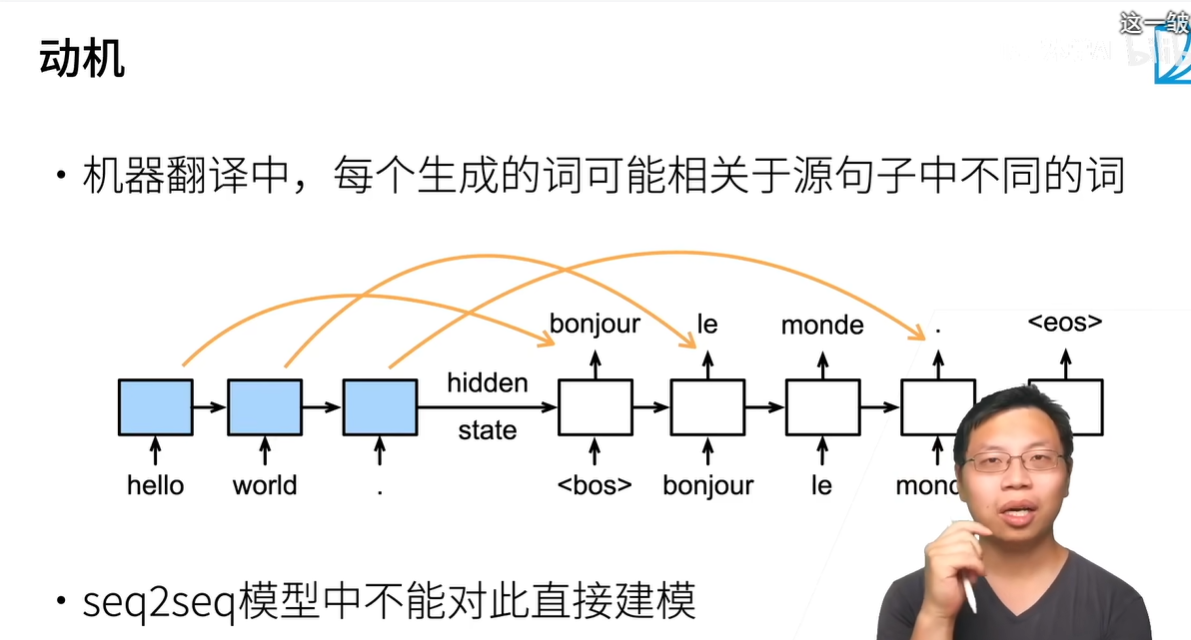
 LSTM模型虽然具有记忆性，但是当编码阶段Encoder输入序列过长时，解码阶段的LSTM也无法很好的针对过早的输入序列解码

# 加入了注意力

对S2S的改进在于 S2S只能看到上一个状态进行输出

现在可以看到所有状态下进行输出 随便找谁都可以

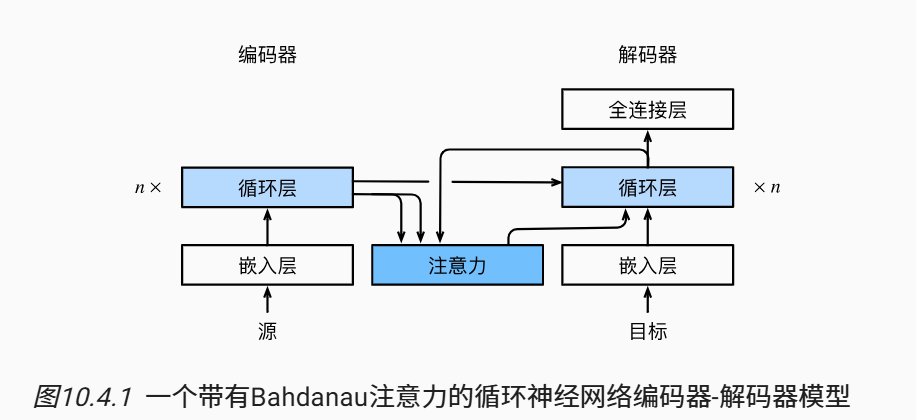

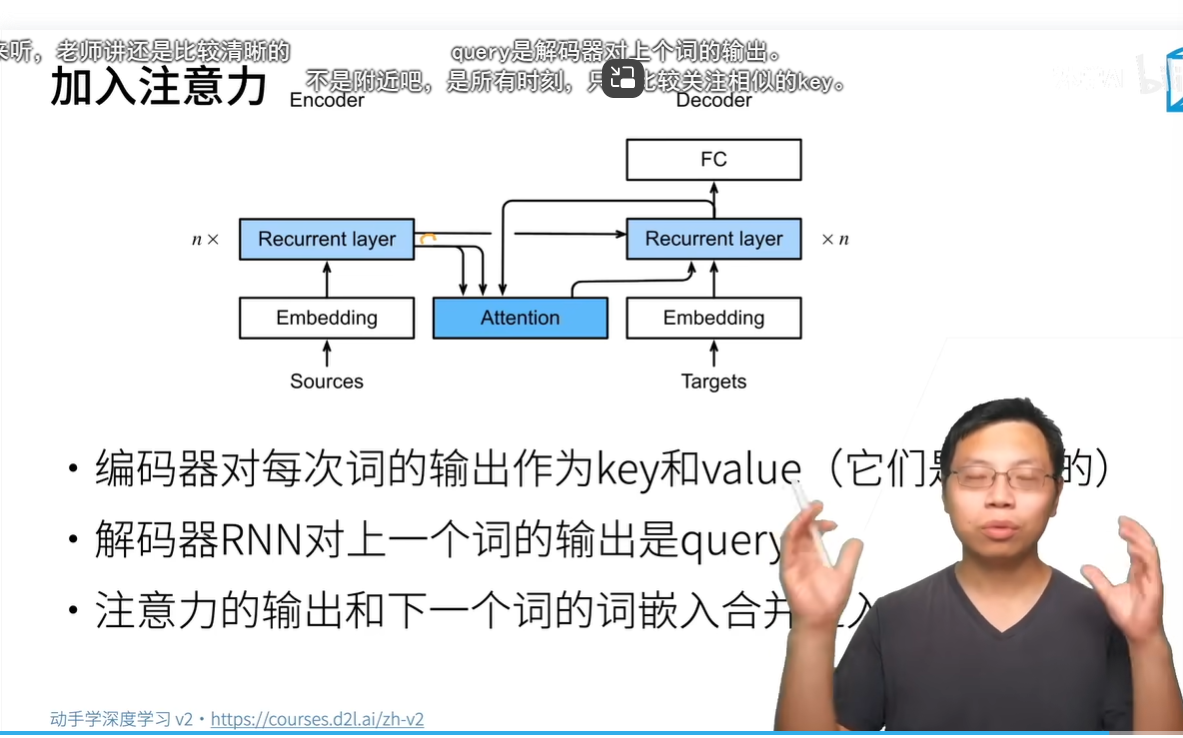

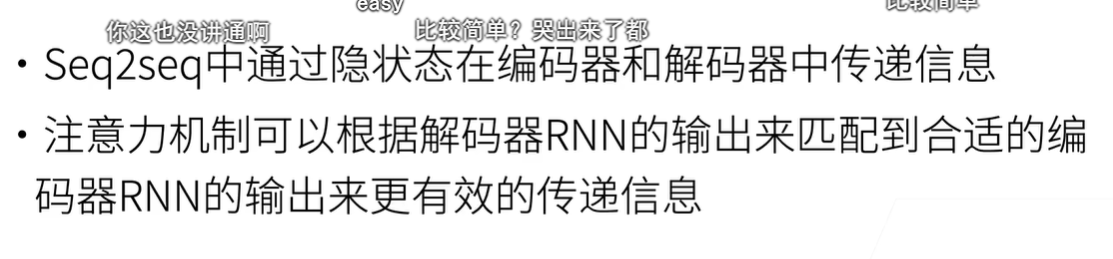

In [2]:
# Bahdanau 注意力

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
# 带有注意力机制的解码器基本接口

# @save 指令表示在使用 d2l 库时，将此类保存到文件中
class AttentionDecoder(d2l.Decoder):
    """带有注意力机制解码器的基本接口"""
    
    def __init__(self, **kwargs):
        """初始化 AttentionDecoder 类"""
        super(AttentionDecoder, self).__init__(**kwargs)
        # 调用父类的初始化方法，初始化解码器基本属性

    @property
    def attention_weights(self):
        """定义一个属性用于获取注意力权重的接口"""
        raise NotImplementedError
        # 如果子类不重写这个方法，调用时将引发 NotImplementedError 错误

In [5]:
# 实现Bahdanau注意力的循环神经网络的解码器
class Seq2SeqAttentionDecoder(AttentionDecoder):
    """具有注意力机制的序列到序列解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        """初始化Seq2SeqAttentionDecoder类
        
        参数:
        - vocab_size: 词汇表大小
        - embed_size: 嵌入层的维度
        - num_hiddens: 隐藏层的维度
        - num_layers: RNN层数
        - dropout: dropout比率
        """
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        # 初始化注意力机制、嵌入层、GRU和全连接层
        self.attention = d2l.AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        
        # 与S2S的模型在这三行中是一摸一样的
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        # 与S2S的模型在这三行中是一摸一样的
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        """初始化解码器的状态
        
        参数:
        - enc_outputs: 编码器的输出
        - enc_valid_lens: 编码输入的有效长度
        
        返回:
        - 返回的状态为一个元组，包含了编码器的输出、隐藏状态和有效长度
        """
        outputs, hidden_state = enc_outputs
        # outputs的形状为(batch_size，num_steps，num_hiddens)
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        """前向传播函数
        
        参数:
        - X: 输入的序列
        - state: 解码器的内部状态
        
        返回:
        - 输出和新的状态
        """
        # 从状态中获取编码输出、隐藏状态和有效长度
        enc_outputs, hidden_state, enc_valid_lens = state
        # X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)  # 将输入进行嵌入并调整维度
        outputs, self._attention_weights = [], []
        
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # 计算上下文向量，形状为(batch_size,1,num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连接上下文向量和当前输入
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)  # 保存当前步骤的输出
            self._attention_weights.append(self.attention.attention_weights)  # 保存注意力权重
        
        # 全连接层变换后，outputs的形状为(num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]

    @property
    def attention_weights(self):
        """获取注意力权重"""
        return self._attention_weights

In [6]:
# 使用包含7个时间步的4个序列输入的小批量测试Bahdanau注意力解码器
# 初始化编码器
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()  # 将编码器设置为评估模式

# 初始化解码器
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.eval()  # 将解码器设置为评估模式

# 创建一个形状为 (batch_size, num_steps) 的零张量，表示输入数据
X = torch.zeros((4, 7), dtype=torch.long)  # (batch_size=4, num_steps=7)

# 使用编码器对输入进行编码，初始化解码器的状态
state = decoder.init_state(encoder(X), None)

# 通过解码器进行前向传播，得到输出和新状态
output, state = decoder(X, state)

# 返回输出的形状，状态的长度，以及状态中各个部分的形状
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

loss 0.020, 14108.6 tokens/sec on cuda:0


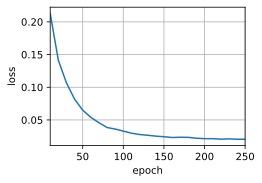

In [11]:
# 设置模型的超参数
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
# 设置批量大小和时间步数
batch_size, num_steps = 64, 10
# 设置学习率、训练轮数和设备（GPU或CPU）
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

# 加载数据集，返回训练迭代器、源语言词汇表和目标语言词汇表
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

# 初始化编码器，传入源语言的词汇量、嵌入维度、隐藏层维度、层数和dropout比率
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)

# 初始化解码器，传入目标语言的词汇量、嵌入维度、隐藏层维度、层数和dropout比率
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)

# 创建一个序列到序列模型，将编码器和解码器结合起来
net = d2l.EncoderDecoder(encoder, decoder)

# 训练序列到序列模型，使用训练迭代器、学习率、训练轮数、目标词汇表和设备
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [12]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => j’ai a payé .,  bleu 0.000
i'm home . => je suis chez moi .,  bleu 1.000


In [13]:
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape((
    1, 1, -1, num_steps))

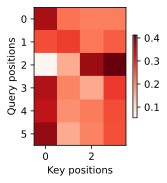

In [14]:
# 加上一个包含序列结束词元
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

# S2S在进行翻译的时候是将前面都设成0只有最后一列设为1

# 而现在加入attention后可以看所有的词进行输出

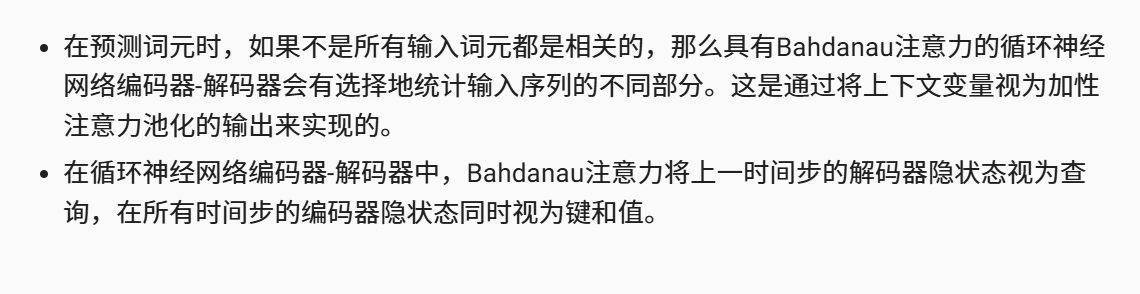